# Dask for Machine Learning

This is a high-level overview demonstrating some the components of Dask-ML.
Visit the main [Dask-ML](http://ml.dask.org) documentation, see the [dask tutorial](https://github.com/dask/dask-tutorial) notebook 08, or explore some of the other machine-learning examples.

In [1]:
from dask.distributed import Client, progress
client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='2GB')
client

Client Scheduler: inproc://10.1.0.4/11751/1 Dashboard: http://10.1.0.4:8787/status,Cluster Workers: 1 Cores: 4 Memory: 2.00 GB


## Distributed Training

<img src="images/scikit-learn-logo-notext.png"/> <img src="images/joblib_logo.svg" width="20%"/> 

Scikit-learn uses [joblib](http://joblib.readthedocs.io/) for single-machine parallelism. This lets you train most estimators (anything that accepts an `n_jobs` parameter) using all the cores of your laptop or workstation.

Alternatively, Scikit-Learn can use Dask for parallelism.  This lets you train those estimators using all the cores of your *cluster* without significantly changing your code.

This is most useful for training large models on medium-sized datasets. You may have a large model when searching over many hyper-parameters, or when using an ensemble method with many individual estimators. For too small datasets, training times will typically be small enough that cluster-wide parallelism isn't helpful. For too large datasets (larger than a single machine's memory), the scikit-learn estimators may not be able to cope (see below).

### Create Scikit-Learn Estimator

In [2]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pandas as pd

We'll use scikit-learn to create a pair of small random arrays, one for the features `X`, and one for the target `y`.

In [3]:
X, y = make_classification(n_samples=1000, random_state=0)
X[:5]

array([[-1.06377997,  0.67640868,  1.06935647, -0.21758002,  0.46021477,
        -0.39916689, -0.07918751,  1.20938491, -0.78531472, -0.17218611,
        -1.08535744, -0.99311895,  0.30693511,  0.06405769, -1.0542328 ,
        -0.52749607, -0.0741832 , -0.35562842,  1.05721416, -0.90259159],
       [ 0.0708476 , -1.69528125,  2.44944917, -0.5304942 , -0.93296221,
         2.86520354,  2.43572851, -1.61850016,  1.30071691,  0.34840246,
         0.54493439,  0.22532411,  0.60556322, -0.19210097, -0.06802699,
         0.9716812 , -1.79204799,  0.01708348, -0.37566904, -0.62323644],
       [ 0.94028404, -0.49214582,  0.67795602, -0.22775445,  1.40175261,
         1.23165333, -0.77746425,  0.01561602,  1.33171299,  1.08477266,
        -0.97805157, -0.05012039,  0.94838552, -0.17342825, -0.47767184,
         0.76089649,  1.00115812, -0.06946407,  1.35904607, -1.18958963],
       [-0.29951677,  0.75988955,  0.18280267, -1.55023271,  0.33821802,
         0.36324148, -2.10052547, -0.4380675 , -

We'll fit a [Support Vector Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), using [grid search](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to find the best value of the $C$ hyperparameter.

In [4]:
param_grid = {"C": [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
              "kernel": ['rbf', 'poly', 'sigmoid'],
              "shrinking": [True, False]}

grid_search = GridSearchCV(SVC(gamma='auto', random_state=0, probability=True),
                           param_grid=param_grid,
                           return_train_score=False,
                           iid=True,
                           cv=3,
                           n_jobs=-1)

To fit that normally, we would call

```python
grid_search.fit(X, y)
```

To fit it using the cluster, we just need to use a context manager provided by joblib.

In [5]:
import joblib

with joblib.parallel_backend('dask'):
    grid_search.fit(X, y)

/usr/share/miniconda3/envs/dask-examples/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


We fit 48 different models, one for each hyper-parameter combination in `param_grid`, distributed across the cluster. At this point, we have a regular scikit-learn model, which can be used for prediction, scoring, etc.

In [6]:
pd.DataFrame(grid_search.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_shrinking,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.336501,0.023972,0.025035,0.008222,0.001,rbf,True,"{'C': 0.001, 'kernel': 'rbf', 'shrinking': True}",0.502994,0.501502,0.501502,0.502,0.000704,41
1,0.282880,0.059722,0.019138,0.001502,0.001,rbf,False,"{'C': 0.001, 'kernel': 'rbf', 'shrinking': False}",0.502994,0.501502,0.501502,0.502,0.000704,41
2,0.176362,0.007028,0.020887,0.004827,0.001,poly,True,"{'C': 0.001, 'kernel': 'poly', 'shrinking': True}",0.502994,0.501502,0.501502,0.502,0.000704,41
3,0.170605,0.011274,0.017563,0.007671,0.001,poly,False,"{'C': 0.001, 'kernel': 'poly', 'shrinking': Fa...",0.502994,0.501502,0.501502,0.502,0.000704,41
4,0.334460,0.014317,0.030271,0.004641,0.001,sigmoid,True,"{'C': 0.001, 'kernel': 'sigmoid', 'shrinking':...",0.502994,0.501502,0.501502,0.502,0.000704,41


In [7]:
grid_search.predict(X)[:5]

array([0, 1, 1, 1, 0])

In [8]:
grid_search.score(X, y)

0.972

For more on training scikit-learn models with distributed joblib, see the [dask-ml documentation](http://dask-ml.readthedocs.io/en/latest/joblib.html).

## Training on Large Datasets

Most estimators in scikit-learn are designed to work on in-memory arrays. Training with larger datasets may require different algorithms.

All of the algorithms implemented in Dask-ML work well on larger than memory datasets, which you might store in a [dask array](http://dask.pydata.org/en/latest/array.html) or [dataframe](http://dask.pydata.org/en/latest/dataframe.html).

In [9]:
%matplotlib inline

In [10]:
import dask_ml.datasets
import dask_ml.cluster
import matplotlib.pyplot as plt

In this example, we'll use `dask_ml.datasets.make_blobs` to generate some random *dask* arrays.

In [11]:
X, y = dask_ml.datasets.make_blobs(n_samples=10000000,
                                   chunks=1000000,
                                   random_state=0,
                                   centers=3)
X = X.persist()
X

dask.array<concatenate, shape=(10000000, 2), dtype=float64, chunksize=(1000000, 2), chunktype=numpy.ndarray>

We'll use the k-means implemented in Dask-ML to cluster the points. It uses the `k-means||` (read: "k-means parallel") initialization algorithm, which scales better than `k-means++`. All of the computation, both during and after initialization, can be done in parallel.

In [12]:
km = dask_ml.cluster.KMeans(n_clusters=3, init_max_iter=2, oversampling_factor=10)
km.fit(X)

KMeans(init_max_iter=2, n_clusters=3, oversampling_factor=10)

We'll plot a sample of points, colored by the cluster each falls into.

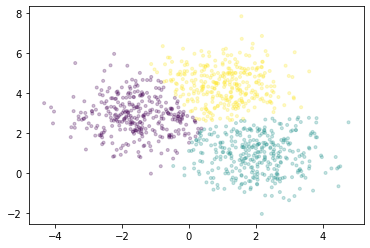

In [13]:
fig, ax = plt.subplots()
ax.scatter(X[::10000, 0], X[::10000, 1], marker='.', c=km.labels_[::10000],
           cmap='viridis', alpha=0.25);

For all the estimators implemented in Dask-ML, see the [API documentation](http://dask-ml.readthedocs.io/en/latest/modules/api.html).